In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA

In [200]:
df = pd.read_csv('/Users/richi/Desktop/GaTech/Classes/II Semester/Data Mining/Project/Data/final.csv')

In [201]:
m = df.shape[0]
n = int(0.8*m)
train = df.iloc[:n,1:]
test = df.iloc[n:,1:]

# Lasso 

In [202]:
mse1 = []

In [203]:
Y = train.iloc[:,-1]
X = train.iloc[:,:-1]
# Cross Validation for alpha tuning
params = {'alpha' : list(np.linspace(0.001,1,20))}
folds = KFold(n_splits=5)
model = linear_model.Lasso()
model_cv = GridSearchCV(estimator=model, param_grid=params, cv=folds,
                        scoring='neg_mean_squared_error', verbose=True)
model_cv.fit(X,Y)
alpha2 = model_cv.best_params_['alpha']

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [204]:
Y_test = test.iloc[:,-1]
X_test = test.iloc[:,:-1]

err = mean_squared_error(Y_test, model_cv.predict(X_test))
mse1.append(err)
print('Testing Error Lasso: ', err)

Testing Error Lasso:  0.24668990282984413


# Random Forest

In [205]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1]
parameters = {'n_estimators':[40,80,100,200,300,400], 'max_depth':[20,50,70,100,150,200]}
mod = RandomForestRegressor(random_state = 29)
rf = GridSearchCV(mod, parameters)
rf.fit(X, y)

GridSearchCV(estimator=RandomForestRegressor(random_state=29),
             param_grid={'max_depth': [20, 50, 70, 100, 150, 200],
                         'n_estimators': [40, 80, 100, 200, 300, 400]})

In [206]:
err = mean_squared_error(y, rf.predict(X))
print('Training RF Error: ', err)

Training RF Error:  0.013320815325007779


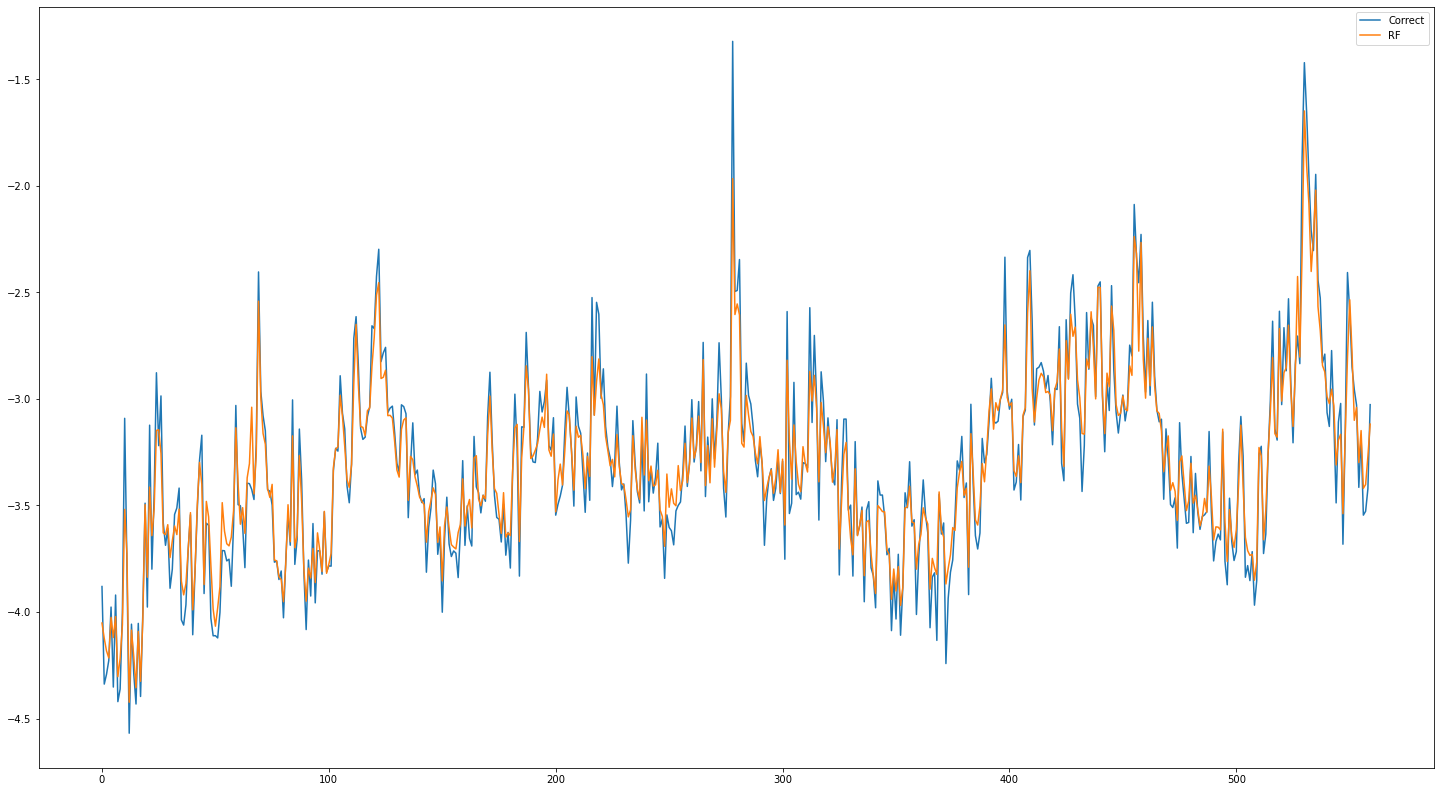

In [207]:
rcParams['figure.figsize'] = (25, 14)
plt.figure()
m = len(train)
plt.plot(range(m),train.iloc[:,-1])
plt.plot(range(m),rf.predict(X))
plt.legend(['Correct','RF'])

In [208]:
y_test = test.iloc[:,-1]
X_test = test.iloc[:,:-1]

err = mean_squared_error(y_test, rf.predict(X_test))
mse1.append(err)
print('Testing RF Error: ', err)

Testing RF Error:  0.29554133693781215


# Gradient Boosting

In [209]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1]
parameters = {'learning_rate':abs(np.log(np.linspace(0.99,0.85,5))), 'n_estimators':[80,100,200,300,400],
             'max_depth':[3,5,10,20]}
mod = GradientBoostingRegressor(random_state = 29)
gbc = GridSearchCV(mod, parameters)
gbc.fit(X, y)

GridSearchCV(estimator=GradientBoostingRegressor(random_state=29),
             param_grid={'learning_rate': array([0.01005034, 0.04604394, 0.08338161, 0.12216763, 0.16251893]),
                         'max_depth': [3, 5, 10, 20],
                         'n_estimators': [80, 100, 200, 300, 400]})

In [210]:
y_test = test.iloc[:,-1]
X_test = test.iloc[:,:-1]

err = mean_squared_error(y_test, gbc.predict(X_test))
mse1.append(err)
print('Testing Boosting Error: ', err)

Testing Boosting Error:  0.2755270194166539


# Plots

Text(0.5, 1.0, 'Prediction without lagged RV')

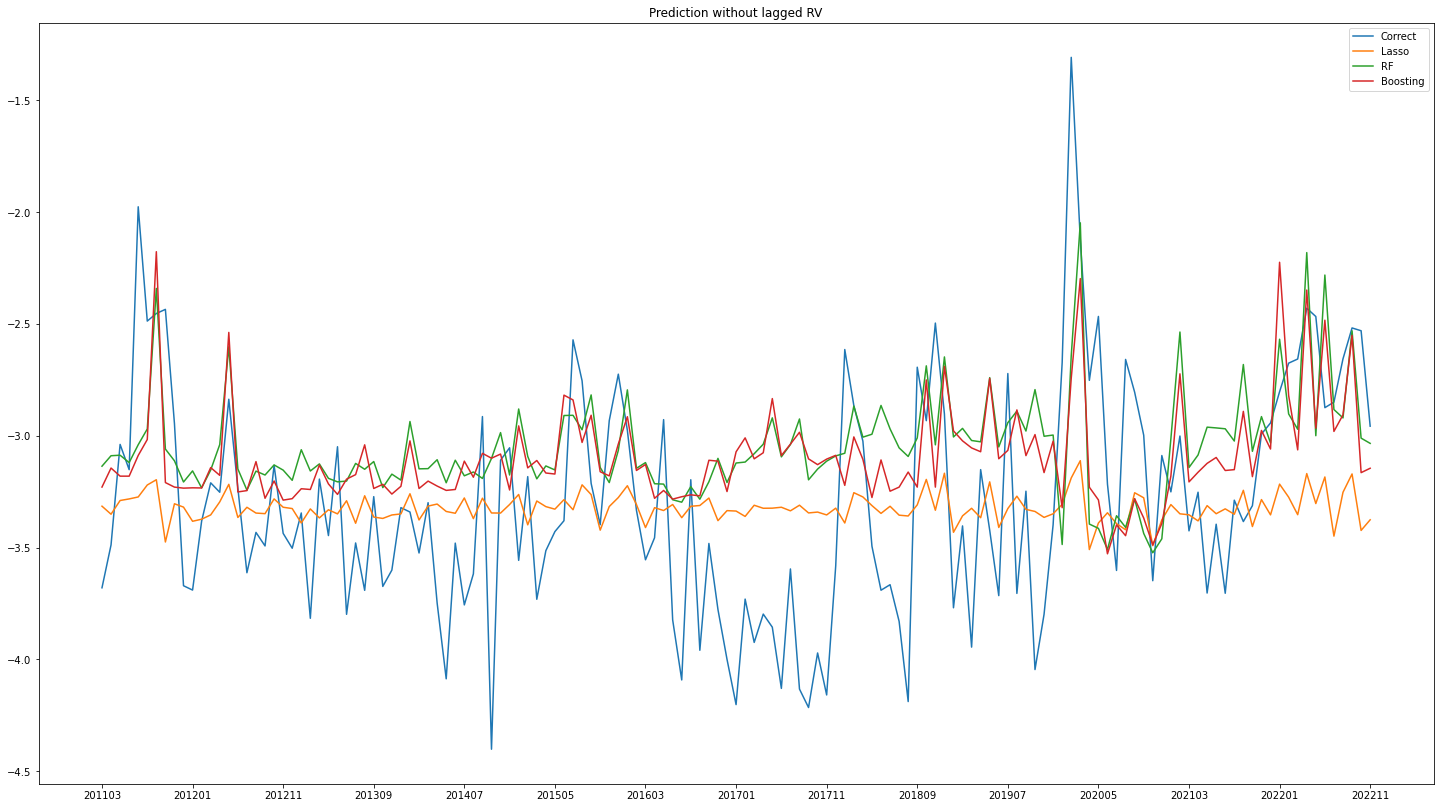

In [216]:
rcParams['figure.figsize'] = (25, 14)
plt.figure()
m = len(test)
ticks = np.arange(0,150,10)
months = df.iloc[n:, 0].reset_index(drop=True)

plt.plot(range(m),test.iloc[:,-1])
plt.plot(range(m),model_cv.predict(X_test))
plt.plot(range(m),rf.predict(X_test))
plt.plot(range(m),gbc.predict(X_test))
plt.xticks(ticks, months[ticks])
plt.legend(['Correct','Lasso','RF','Boosting'])
plt.title('Prediction without lagged RV')

In [220]:
mse1 = pd.DataFrame(mse1)
mse1 = mse1.rename(columns={0:'Testing MSE'}, index={0:'Lasso',1:'Random Forest',2:'Boosting'})

In [221]:
mse1 

,Testing MSE
Lasso,0.246690
Random Forest,0.295541
Boosting,0.275527


# 3. Drop some features

In [260]:
# Due to low training error and high testing error (overfitting), we reduce the features and 
# add the lagged value of the dependent variable, which could have some information

In [261]:
df = pd.read_csv('/Users/richi/Desktop/GaTech/Classes/II Semester/Data Mining/Project/Data/final.csv')

In [262]:
df_new = df.iloc[:,:-1]
df_new['RV-1'] = df['RV'].shift(1)
df_new['RV'] = df['RV']
df = df_new
df.dropna(inplace = True)

In [263]:
m = df.shape[0]
n = int(0.8*m)
train = df.iloc[:n,1:]
test = df.iloc[n:,1:]

# 3.1 Stepwise search

In [264]:
# Stepwise Search using AIC

Y = train.iloc[:,-1]
X = train.iloc[:,:-1]
A2 = pd.DataFrame()

k = X.shape[1]
count = 0

while count < k:
    
    aics = []
    
    for i in range(X.shape[1]):
        x = pd.concat([A2, X.iloc[:,i]], axis = 1)
        x = sm.add_constant(x)
        reg = sm.OLS(Y,x).fit()
        aics.append(reg.aic)
    
    c = aics.index(min(aics))
    z = list(range(X.shape[1]))
    z.remove(c)
    
    # confront selection with backward:
    if count == 0 or A2.empty:
        A_temp = pd.DataFrame(X.shape[0]*[1])
        reg1 = sm.OLS(np.array(Y),np.matrix(A_temp)).fit()
        
    else:
        temp1 = sm.add_constant(A2)
        reg1 = sm.OLS(Y,temp1).fit()
    
    temp2 = pd.concat([A2, X.iloc[:,c]], axis = 1)
    temp2 = sm.add_constant(temp2)
    reg2 = sm.OLS(Y,temp2).fit()
    
    if reg2.aic < reg1.aic:
        A2 = pd.concat([A2, X.iloc[:,c]], axis = 1)
        
    X = X.iloc[:,z]
    count = count + 1    

In [265]:
A2.columns

Index(['RV-1', 'Mkt-RF', 'IP', 'STR', 'DP', 'INF', 'TS', 'TB'], dtype='object')

In [266]:
cols = list(A2.columns)+['RV']
train = train[cols]
test = test[cols]

# 3.2 Random Forest

In [267]:
mse2 = []

In [268]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1]
parameters = {'n_estimators':[40,80,100,200,300,400], 'max_depth':[20,50,70,100,150,200]}
mod = RandomForestRegressor(random_state = 29)
rf = GridSearchCV(mod, parameters)
rf.fit(X, y)

GridSearchCV(estimator=RandomForestRegressor(random_state=29),
             param_grid={'max_depth': [20, 50, 70, 100, 150, 200],
                         'n_estimators': [40, 80, 100, 200, 300, 400]})

In [269]:
err = mean_squared_error(y, rf.predict(X))
print('Training RF Error: ', err)

Training RF Error:  0.01235220247634191


In [270]:
y_test = test.iloc[:,-1]
X_test = test.iloc[:,:-1]

err = mean_squared_error(y_test, rf.predict(X_test))
mse2.append(err)
print('Testing RF Error: ', err)

Testing RF Error:  0.19898048662197815


# 3.3 Boosting

In [271]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1]
parameters = {'learning_rate':abs(np.log(np.linspace(0.99,0.85,5))), 'n_estimators':[80,100,200,300,400],
             'max_depth':[3,5,10,20]}
mod = GradientBoostingRegressor(random_state = 29)
gbc = GridSearchCV(mod, parameters)
gbc.fit(X, y)

GridSearchCV(estimator=GradientBoostingRegressor(random_state=29),
             param_grid={'learning_rate': array([0.01005034, 0.04604394, 0.08338161, 0.12216763, 0.16251893]),
                         'max_depth': [3, 5, 10, 20],
                         'n_estimators': [80, 100, 200, 300, 400]})

In [272]:
err = mean_squared_error(y, gbc.predict(X))
print('Training Boosting Error: ', err)

Training Boosting Error:  0.06805897448426111


In [273]:
y_test = test.iloc[:,-1]
X_test = test.iloc[:,:-1]

err = mean_squared_error(y_test, gbc.predict(X_test))
mse2.append(err)
print('Testing Boosting Error: ', err)

Testing Boosting Error:  0.1897090147082396


# 3.4 Lasso

In [274]:
Y = train.iloc[:,-1]
X = train.iloc[:,:-1]
# Cross Validation for alpha tuning
params = {'alpha' : list(np.linspace(0.001,1,20))}
folds = KFold(n_splits=5)
model = linear_model.Lasso()
model_cv = GridSearchCV(estimator=model, param_grid=params, cv=folds,
                        scoring='neg_mean_squared_error', verbose=True)
model_cv.fit(X,Y)
alpha2 = model_cv.best_params_['alpha']

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [275]:
err = mean_squared_error(Y, model_cv.predict(X))
print('Training Lasso Error: ', err)

Training Lasso Error:  0.08829249654288893


In [276]:
Y_test = test.iloc[:,-1]
X_test = test.iloc[:,:-1]

err = mean_squared_error(Y_test, model_cv.predict(X_test))
mse2.append(err)
print('Testing Error Lasso: ', err)

Testing Error Lasso:  0.19170376757431298


# Plot Results

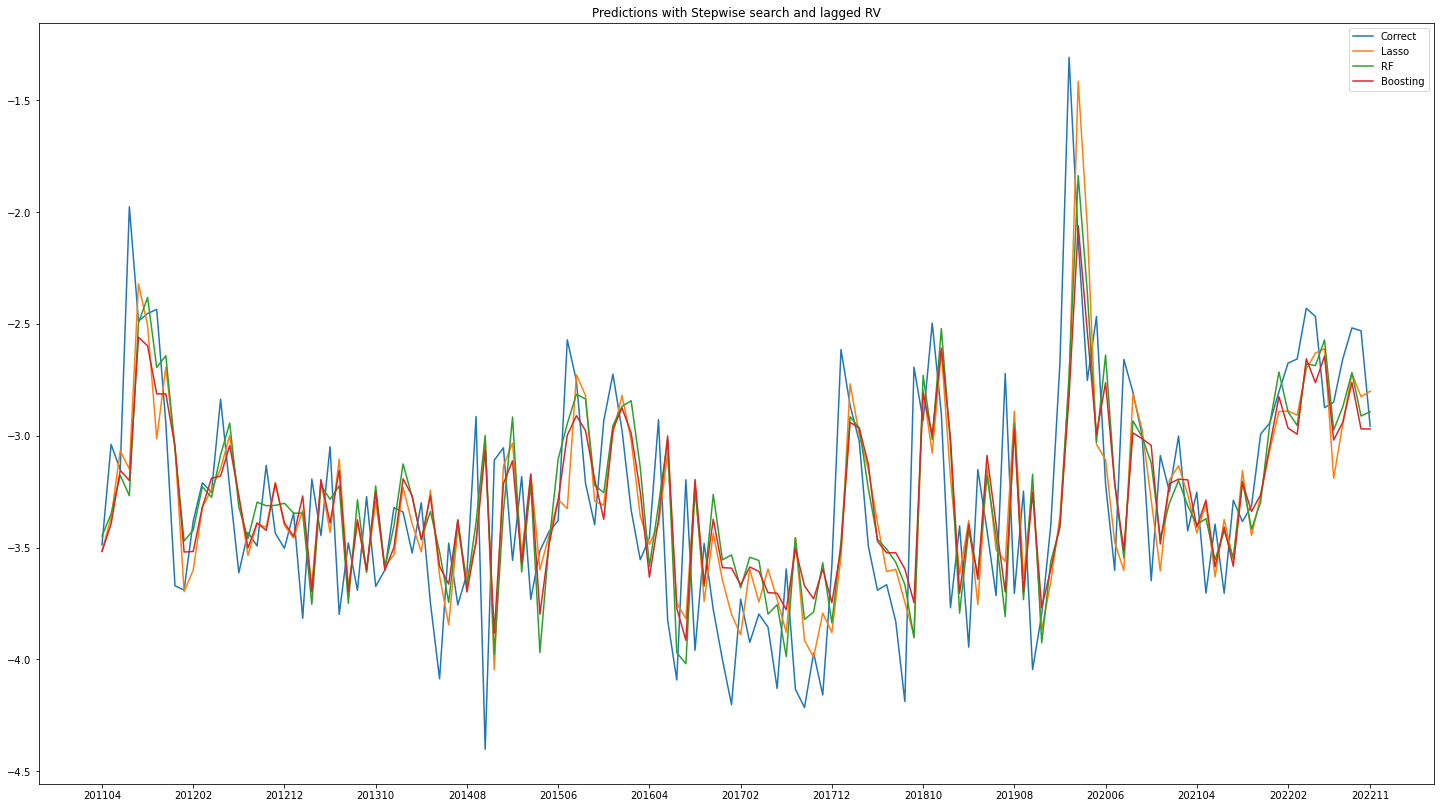

In [277]:
rcParams['figure.figsize'] = (25, 14)
plt.figure()
m = len(test)
ticks = np.arange(0,140,10)
ticks = np.append(ticks,139)
months = df.iloc[n:, 0].reset_index(drop=True)

plt.plot(range(m),test.iloc[:,-1])
plt.plot(range(m),model_cv.predict(X_test))
plt.plot(range(m),rf.predict(X_test))
plt.plot(range(m),gbc.predict(X_test))
plt.xticks(ticks,months[ticks])
plt.title('Predictions with Stepwise search and lagged RV')
plt.legend(['Correct','Lasso','RF','Boosting'])

In [278]:
mse2 = [mse2[2],mse2[0],mse2[1]]
mse2 = pd.DataFrame(mse2)
mse2 = mse2.rename(columns={0:'Testing MSE'}, index={0:'Lasso',1:'Random Forest',2:'Boosting'})

In [279]:
mse2

,Testing MSE
Lasso,0.191704
Random Forest,0.198980
Boosting,0.189709


# 4. PCA

In [280]:
df = pd.read_csv('/Users/richi/Desktop/GaTech/Classes/II Semester/Data Mining/Project/Data/final.csv')

In [281]:
X = df.iloc[:,1:-1]
pca = PCA(n_components=5)
Xnew = pca.fit_transform(X)
pca = pca.explained_variance_ratio_

In [282]:
sum(pca)

0.9273862820006623

In [283]:
Xnew = pd.DataFrame(Xnew)
Xnew['RV-1'] =df['RV'].shift(1)
Xnew['RV'] = df['RV']
Xnew.dropna(inplace=True)

In [284]:
m = Xnew.shape[0]
n = int(0.8*m)
train = Xnew.iloc[:n,:]
test = Xnew.iloc[n:,:]

# 4.1 Random Forest

In [285]:
mse3 = []

In [286]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1]
parameters = {'n_estimators':[40,80,100,200,300,400], 'max_depth':[20,50,70,100,150,200]}
mod = RandomForestRegressor(random_state = 29)
rf = GridSearchCV(mod, parameters)
rf.fit(X, y)

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

GridSearchCV(estimator=RandomForestRegressor(random_state=29),
             param_grid={'max_depth': [20, 50, 70, 100, 150, 200],
                         'n_estimators': [40, 80, 100, 200, 300, 400]})

In [287]:
err = mean_squared_error(y, rf.predict(X))
print('Training RF Error: ', err)

Training RF Error:  0.01331689926429563


/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [288]:
y_test = test.iloc[:,-1]
X_test = test.iloc[:,:-1]

err = mean_squared_error(y_test, rf.predict(X_test))
mse3.append(err)
print('Testing RF Error: ', err)

Testing RF Error:  0.21344861595336329


/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


# 4.2 Gradient Boosting

In [289]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1]
parameters = {'learning_rate':abs(np.log(np.linspace(0.99,0.85,5))), 'n_estimators':[80,100,200,300,400],
             'max_depth':[3,5,10,20]}
mod = GradientBoostingRegressor(random_state = 29)
gbc = GridSearchCV(mod, parameters)
gbc.fit(X, y)

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

GridSearchCV(estimator=GradientBoostingRegressor(random_state=29),
             param_grid={'learning_rate': array([0.01005034, 0.04604394, 0.08338161, 0.12216763, 0.16251893]),
                         'max_depth': [3, 5, 10, 20],
                         'n_estimators': [80, 100, 200, 300, 400]})

In [290]:
err = mean_squared_error(y, gbc.predict(X))
print('Training Boosting Error: ', err)

Training Boosting Error:  0.055576220258176115


/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [291]:
y_test = test.iloc[:,-1]
X_test = test.iloc[:,:-1]

err = mean_squared_error(y_test, gbc.predict(X_test))
mse3.append(err)
print('Testing Boosting Error: ', err)

Testing Boosting Error:  0.195317402737666


/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


# 4.3 Lasso

In [292]:
Y = train.iloc[:,-1]
X = train.iloc[:,:-1]
# Cross Validation for alpha tuning
params = {'alpha' : list(np.linspace(0.001,1,20))}
folds = KFold(n_splits=5)
model = linear_model.Lasso()
model_cv = GridSearchCV(estimator=model, param_grid=params, cv=folds,
                        scoring='neg_mean_squared_error', verbose=True)
model_cv.fit(X,Y)
alpha2 = model_cv.best_params_['alpha']

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.

In [293]:
err = mean_squared_error(Y, model_cv.predict(X))
print('Training Lasso Error: ', err)

Training Lasso Error:  0.08993950360683158


/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [294]:
Y_test = test.iloc[:,-1]
X_test = test.iloc[:,:-1]

err = mean_squared_error(Y_test, model_cv.predict(X_test))
mse3.append(err)
print('Testing Error Lasso: ', err)

Testing Error Lasso:  0.19469801263142514


/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [295]:
mse3 = [mse3[2],mse3[0],mse3[1]]
mse3 = pd.DataFrame(mse3)
mse3 = mse3.rename(columns={0:'Testing MSE'}, index={0:'Lasso',1:'Random Forest',2:'Boosting'})

In [296]:
mse3

,Testing MSE
Lasso,0.194698
Random Forest,0.213449
Boosting,0.195317


/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


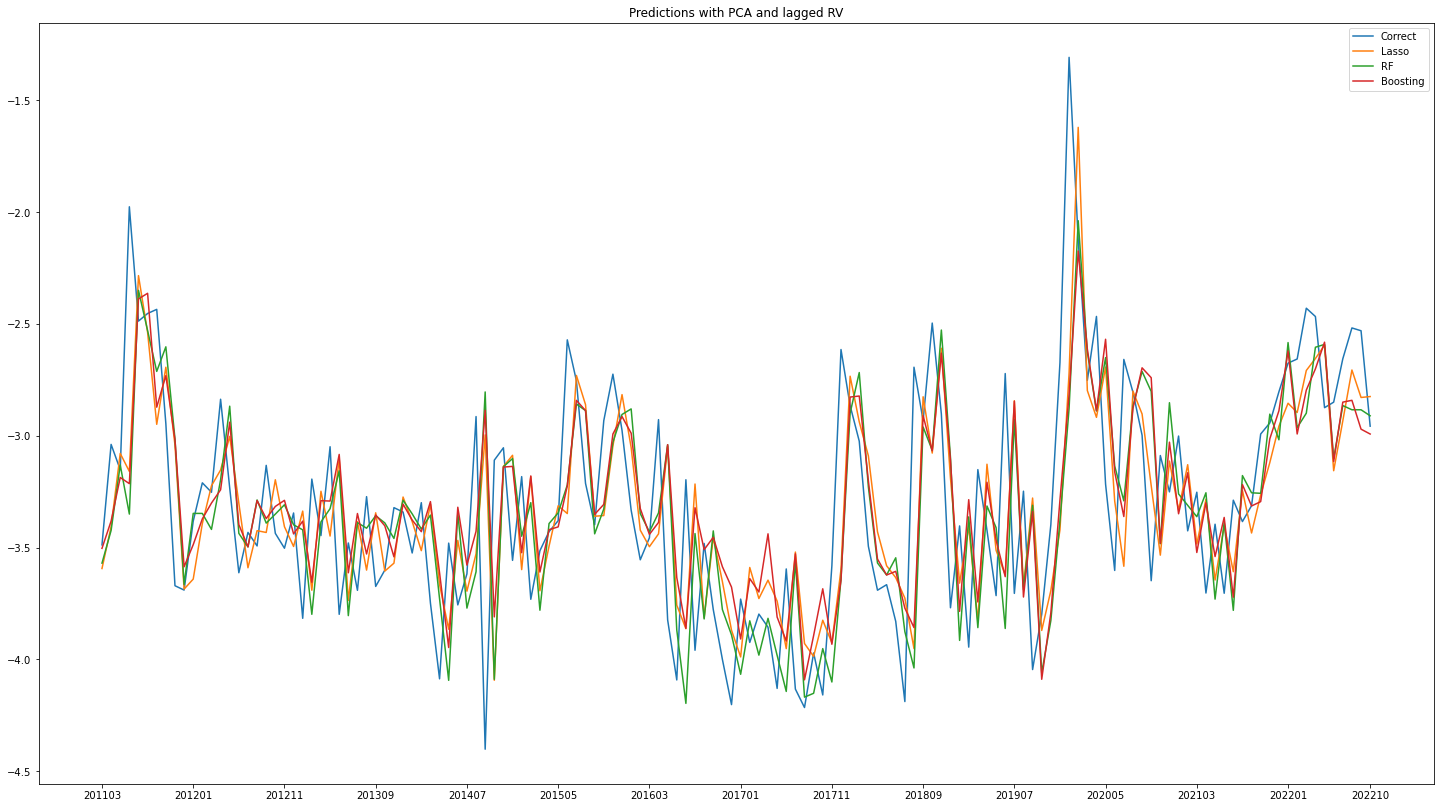

In [297]:
rcParams['figure.figsize'] = (25, 14)
plt.figure()
m = len(test)
ticks = np.arange(0,140,10)
ticks = np.append(ticks,139)
months = df.iloc[n:, 0].reset_index(drop=True)

plt.plot(range(m),test.iloc[:,-1])
plt.plot(range(m),model_cv.predict(X_test))
plt.plot(range(m),rf.predict(X_test))
plt.plot(range(m),gbc.predict(X_test))
plt.xticks(ticks,months[ticks])
plt.title('Predictions with PCA and lagged RV')
plt.legend(['Correct','Lasso','RF','Boosting'])